# PPO TRAINING

This script trains PPO agents with various hyperparameter configurations
and tracks performance metrics for comparison with DQN.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
import json
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All imports successful!")
print(f"Working directory: {os.getcwd()}")

✓ All imports successful!
Working directory: c:\Users\HP\Programming\ML\fire_rescue_agent\training


# PPO HYPERPARAMETER CONFIGURATIONS

Key PPO Hyperparameters:
- learning_rate: Step size for gradient updates
- gamma: Discount factor (same as DQN)
- batch_size: Number of experiences per update (different meaning than DQN)
- n_steps: Steps collected before update (PPO-specific)
- n_epochs: Number of passes through collected data (PPO-specific)
- clip_range: PPO clipping parameter (PPO-specific)
- gae_lambda: GAE parameter for advantage estimation (PPO-specific)
- ent_coef: Entropy coefficient for exploration (PPO-specific)
- vf_coef: Value function coefficient (PPO-specific)

Shared with DQN configs where possible:
- learning_rate, gamma, network architecture


In [2]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 2: IMPORT CUSTOM ENVIRONMENT
# ═══════════════════════════════════════════════════════════════════════
"""
Import Fire-Rescue environment
"""

import sys
import os

# Add parent directory to path to access sibling folders
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Import environment
from environment.custom_env import FireRescueEnv

print("✓ FireRescueEnv imported successfully")

✓ FireRescueEnv imported successfully


In [3]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 3: PPO HYPERPARAMETER CONFIGURATIONS
# ═══════════════════════════════════════════════════════════════════════
"""
Define all 11 PPO configurations
- Configs 2, 3, 6, 7 mirror DQN configs for direct comparison
- Configs 8, 9, 11 test PPO-specific parameters
- Config 10 is the optimized configuration
"""

PPO_CONFIGS = {
    # ─────────────────────────────────────────────────────────────────────
    # Config 1: BASELINE
    # ─────────────────────────────────────────────────────────────────────
    "config_1_baseline": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Baseline - Standard PPO settings"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 2: HIGH LEARNING RATE (Matches DQN config 2)
    # ─────────────────────────────────────────────────────────────────────
    "config_2_high_lr": {
        "learning_rate": 5e-3,
        "gamma": 0.99,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High LR - Compare with DQN config 2"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 3: LOW LEARNING RATE (Matches DQN config 3)
    # ─────────────────────────────────────────────────────────────────────
    "config_3_low_lr": {
        "learning_rate": 1e-5,
        "gamma": 0.99,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low LR - Compare with DQN config 3"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 4: LARGE BATCH
    # ─────────────────────────────────────────────────────────────────────
    "config_4_large_batch": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 256,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Large Batch - Stable gradients"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 5: SMALL BATCH
    # ─────────────────────────────────────────────────────────────────────
    "config_5_small_batch": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 32,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Small Batch - Fast updates"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 6: LOW GAMMA (Matches DQN config 6)
    # ─────────────────────────────────────────────────────────────────────
    "config_6_low_gamma": {
        "learning_rate": 3e-4,
        "gamma": 0.95,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low Gamma - Compare with DQN config 6"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 7: HIGH GAMMA (Matches DQN config 7)
    # ─────────────────────────────────────────────────────────────────────
    "config_7_high_gamma": {
        "learning_rate": 3e-4,
        "gamma": 0.995,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High Gamma - Compare with DQN config 7"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 8: HIGH ENTROPY (PPO-specific)
    # ─────────────────────────────────────────────────────────────────────
    "config_8_high_entropy": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.1,  # High entropy
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "High Entropy - More exploration"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 9: LOW ENTROPY (PPO-specific)
    # ─────────────────────────────────────────────────────────────────────
    "config_9_low_entropy": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 10,
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.0,  # No entropy
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Low Entropy - Pure exploitation"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 10: OPTIMIZED
    # ─────────────────────────────────────────────────────────────────────
    "config_10_optimized": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 128,
        "n_steps": 4096,  # More steps
        "n_epochs": 15,  # More epochs
        "clip_range": 0.2,
        "gae_lambda": 0.98,
        "ent_coef": 0.02,
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[128, 128]),  # Deeper
        "description": "Optimized - Best guess for task"
    },
    
    # ─────────────────────────────────────────────────────────────────────
    # Config 11: MANY EPOCHS (PPO-specific)
    # ─────────────────────────────────────────────────────────────────────
    "config_11_many_epochs": {
        "learning_rate": 3e-4,
        "gamma": 0.99,
        "batch_size": 64,
        "n_steps": 2048,
        "n_epochs": 20,  # Many epochs
        "clip_range": 0.2,
        "gae_lambda": 0.95,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "policy_kwargs": dict(net_arch=[64, 64]),
        "description": "Many Epochs - Sample efficient"
    },
}

# Print configuration summary
print(f"✓ Defined {len(PPO_CONFIGS)} PPO configurations\n")
print("="*110)
print(f"{'Config':<30} {'LR':<10} {'Gamma':<8} {'Batch':<8} {'N_Steps':<10} {'Epochs':<8} {'Ent_Coef':<12} {'Network':<12}")
print("="*110)

for config_name, config in PPO_CONFIGS.items():
    net_arch = str(config['policy_kwargs']['net_arch'])
    print(f"{config_name:<30} {config['learning_rate']:<10.0e} {config['gamma']:<8.3f} "
          f"{config['batch_size']:<8} {config['n_steps']:<10} "
          f"{config['n_epochs']:<8} {config['ent_coef']:<12.2f} {net_arch:<12}")

print("="*110)

✓ Defined 11 PPO configurations

Config                         LR         Gamma    Batch    N_Steps    Epochs   Ent_Coef     Network     
config_1_baseline              3e-04      0.990    64       2048       10       0.01         [64, 64]    
config_2_high_lr               5e-03      0.990    64       2048       10       0.01         [64, 64]    
config_3_low_lr                1e-05      0.990    64       2048       10       0.01         [64, 64]    
config_4_large_batch           3e-04      0.990    256      2048       10       0.01         [64, 64]    
config_5_small_batch           3e-04      0.990    32       2048       10       0.01         [64, 64]    
config_6_low_gamma             3e-04      0.950    64       2048       10       0.01         [64, 64]    
config_7_high_gamma            3e-04      0.995    64       2048       10       0.01         [64, 64]    
config_8_high_entropy          3e-04      0.990    64       2048       10       0.10         [64, 64]    
config_9_low_

In [4]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 4: CUSTOM CALLBACK FOR METRICS TRACKING
# ═══════════════════════════════════════════════════════════════════════
"""
Custom callback to track training metrics in real-time
"""

class MetricsCallback(BaseCallback):
    """
    Tracks episode rewards, lengths, and performs periodic evaluation
    """
    def __init__(self, eval_env, eval_freq=5000, verbose=1):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.episode_rewards = []
        self.episode_lengths = []
        self.eval_rewards = []
        self.eval_stds = []
        self.timesteps = []
        
    def _on_step(self):
        # Log episode metrics
        if len(self.model.ep_info_buffer) > 0:
            for info in self.model.ep_info_buffer:
                if 'r' in info:
                    self.episode_rewards.append(info['r'])
                if 'l' in info:
                    self.episode_lengths.append(info['l'])
        
        # Periodic evaluation
        if self.n_calls % self.eval_freq == 0:
            mean_reward, std_reward = evaluate_policy(
                self.model, 
                self.eval_env, 
                n_eval_episodes=10,
                deterministic=True
            )
            self.eval_rewards.append(mean_reward)
            self.eval_stds.append(std_reward)
            self.timesteps.append(self.num_timesteps)
            
            if self.verbose > 0:
                print(f"  [Eval] Step {self.num_timesteps:>6}: "
                      f"Reward = {mean_reward:>7.2f} ± {std_reward:>5.2f}")
        
        return True

print("✓ MetricsCallback class defined")

✓ MetricsCallback class defined


In [5]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 5: TRAINING FUNCTION
# ═══════════════════════════════════════════════════════════════════════
"""
Main training function for a single configuration
"""

def train_ppo_config(config_name, config, total_timesteps=100000, save_dir="models/ppo"):
    """
    Train PPO agent with specified configuration
    
    Args:
        config_name: Name of configuration
        config: Dict of hyperparameters
        total_timesteps: Total training steps
        save_dir: Directory to save models
    
    Returns:
        Dictionary with training results
    """
    print(f"\n{'='*80}")
    print(f"🚀 Training: {config_name}")
    print(f"📝 {config['description']}")
    print(f"{'='*80}")
    
    # Create directories
    os.makedirs(save_dir, exist_ok=True)
    config_dir = os.path.join(save_dir, config_name)
    os.makedirs(config_dir, exist_ok=True)
    
    # Create environments
    env = FireRescueEnv()
    eval_env = FireRescueEnv()
    
    # Extract PPO parameters
    ppo_params = {k: v for k, v in config.items() 
                  if k not in ['description', 'policy_kwargs']}
    ppo_params['policy_kwargs'] = config['policy_kwargs']
    
    # Create model
    print(f"\n📊 Creating PPO model...")
    model = PPO(
        "MlpPolicy",
        env,
        verbose=0,  # Set to 0 for cleaner output
        tensorboard_log=os.path.join(config_dir, "tensorboard"),
        **ppo_params
    )
    
    # Create callback
    callback = MetricsCallback(eval_env, eval_freq=5000, verbose=1)
    
    # Train
    print(f"🎓 Training for {total_timesteps:,} timesteps...\n")
    start_time = datetime.now()
    
    model.learn(
        total_timesteps=total_timesteps,
        callback=callback,
        progress_bar=True
    )
    
    training_time = (datetime.now() - start_time).total_seconds()
    
    # Final evaluation (100 episodes)
    print(f"\n🧪 Final evaluation (100 episodes)...")
    mean_reward, std_reward = evaluate_policy(
        model, 
        eval_env, 
        n_eval_episodes=100,
        deterministic=True
    )
    
    # Calculate success rate
    print(f"🎯 Calculating success rate...")
    success_count = 0
    for _ in range(100):
        obs, _ = eval_env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = eval_env.step(action)
            done = terminated or truncated
            if info.get('success', False):
                success_count += 1
                break
    
    success_rate = success_count / 100.0
    
    # Save model
    model_path = os.path.join(config_dir, "final_model")
    model.save(model_path)
    
    # Save results
    results = {
        "config_name": config_name,
        "config": config,
        "mean_reward": float(mean_reward),
        "std_reward": float(std_reward),
        "success_rate": float(success_rate),
        "training_time": training_time,
        "total_timesteps": total_timesteps,
        "eval_timesteps": callback.timesteps,
        "eval_rewards": callback.eval_rewards,
        "eval_stds": callback.eval_stds,
    }
    
    with open(os.path.join(config_dir, "results.json"), 'w') as f:
        json.dump(results, f, indent=4)
    
    # Plot training curve
    if len(callback.timesteps) > 0:
        plt.figure(figsize=(12, 6))
        plt.plot(callback.timesteps, callback.eval_rewards, 'b-', linewidth=2, marker='o')
        plt.fill_between(callback.timesteps, 
                         np.array(callback.eval_rewards) - np.array(callback.eval_stds),
                         np.array(callback.eval_rewards) + np.array(callback.eval_stds),
                         alpha=0.3)
        plt.xlabel('Timesteps', fontsize=14)
        plt.ylabel('Mean Reward', fontsize=14)
        plt.title(f'{config_name}\nFinal: {mean_reward:.2f} ± {std_reward:.2f} | Success: {success_rate:.1%}', 
                  fontsize=16, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(config_dir, "training_curve.png"), dpi=150, bbox_inches='tight')
        plt.show()
    
    # Print summary
    print(f"\n{'='*80}")
    print(f"✅ RESULTS for {config_name}:")
    print(f"   📈 Mean Reward: {mean_reward:.2f} ± {std_reward:.2f}")
    print(f"   🎯 Success Rate: {success_rate:.1%}")
    print(f"   ⏱️  Training Time: {training_time:.1f}s ({training_time/60:.1f} min)")
    print(f"   💾 Saved to: {config_dir}")
    print(f"{'='*80}\n")
    
    # Cleanup
    env.close()
    eval_env.close()
    
    return results

print("✓ Training function defined")

✓ Training function defined



🎯 PPO HYPERPARAMETER TUNING - FIRE RESCUE ENVIRONMENT

📊 Total Configs: 11
⏱️  Timesteps per config: 100,000
📈 Total training timesteps: 1,100,000

⚠️  This will take approximately 22.0 hours
    (Estimate: ~10 min per config)



🔄 Progress: 1/11 configurations

🚀 Training: config_1_baseline
📝 Baseline - Standard PPO settings

📊 Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -98.49 ± 24.08

[Eval] Step  10000: Reward =   34.31 ± 50.51

[Eval] Step  15000: Reward =  -60.09 ± 74.76

[Eval] Step  20000: Reward =  -25.09 ± 78.14

[Eval] Step  25000: Reward =   16.21 ± 68.71

[Eval] Step  30000: Reward =   49.81 ±  1.10

[Eval] Step  35000: Reward =   48.81 ±  1.00

[Eval] Step  40000: Reward =   33.21 ± 48.82

[Eval] Step  45000: Reward =   49.01 ±  1.66

[Eval] Step  50000: Reward =   49.41 ±  1.28

[Eval] Step  55000: Reward =   48.81 ±  1.26

[Eval] Step  60000: Reward =   49.31 ±  1.63

[Eval] Step  65000: Reward =   49.51 ±  1.27

[Eval] Step  70000: Reward =   49.41 ±  1.56

[Eval] Step  75000: Reward =   49.61 ±  1.47

[Eval] Step  80000: Reward =   48.81 ±  1.26

[Eval] Step  85000: Reward =   48.91 ±  1.37

[Eval] Step  90000: Reward =   49.51 ±  1.27

[Eval] Step  95000: Reward =   48.81 ±  1.34

[Eval] Step 100000: Reward =   49.71 ±  1.37


🧪 Final evaluation (100 episodes)...
🎯 Calculating success rate...


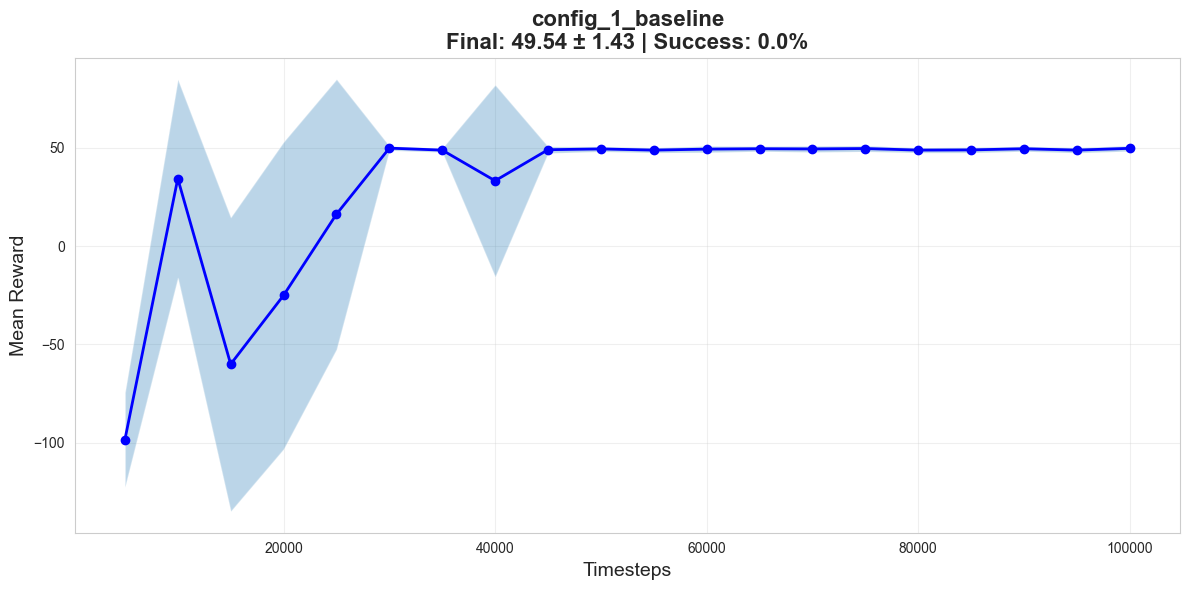


✅ RESULTS for config_1_baseline:
   📈 Mean Reward: 49.54 ± 1.43
   🎯 Success Rate: 0.0%
   ⏱️  Training Time: 118.5s (2.0 min)
   💾 Saved to: models/ppo\config_1_baseline


🔄 Progress: 2/11 configurations

🚀 Training: config_2_high_lr
📝 High LR - Compare with DQN config 2

📊 Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -61.49 ± 55.05

[Eval] Step  10000: Reward =  -47.14 ± 54.70

[Eval] Step  15000: Reward =   17.41 ± 45.68

[Eval] Step  20000: Reward =  104.41 ± 104.15

[Eval] Step  25000: Reward =  124.36 ± 124.59

[Eval] Step  30000: Reward =  130.16 ± 115.44

[Eval] Step  35000: Reward =  168.71 ± 78.30

[Eval] Step  40000: Reward =  106.21 ± 147.35

[Eval] Step  45000: Reward =   83.71 ± 164.88

[Eval] Step  50000: Reward =  201.36 ± 35.96

[Eval] Step  55000: Reward =  155.91 ± 69.06

[Eval] Step  60000: Reward =  166.66 ± 106.23

[Eval] Step  65000: Reward =  121.16 ± 110.12

[Eval] Step  70000: Reward =   68.86 ± 149.75

[Eval] Step  75000: Reward =  -27.19 ± 106.50

[Eval] Step  80000: Reward =  -62.74 ± 13.31

[Eval] Step  85000: Reward =  -78.74 ± 39.68

[Eval] Step  90000: Reward =  -74.49 ± 55.47

[Eval] Step  95000: Reward =   18.36 ± 55.57

[Eval] Step 100000: Reward =  -40.24 ± 51.91


🧪 Final evaluation (100 episodes)...
🎯 Calculating success rate...


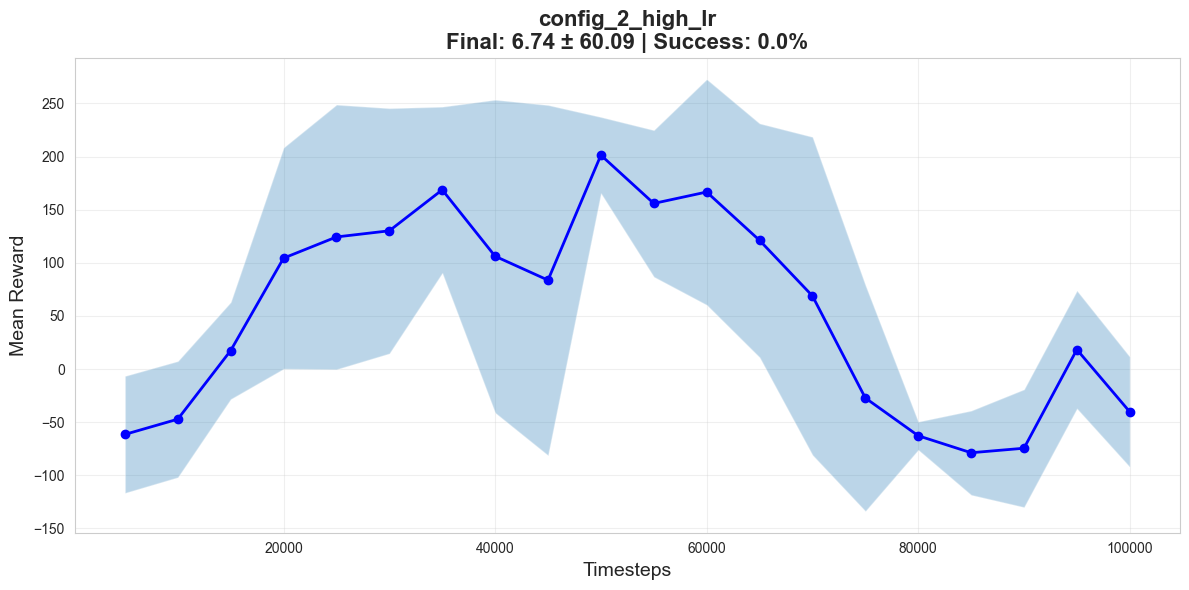


✅ RESULTS for config_2_high_lr:
   📈 Mean Reward: 6.74 ± 60.09
   🎯 Success Rate: 0.0%
   ⏱️  Training Time: 130.1s (2.2 min)
   💾 Saved to: models/ppo\config_2_high_lr


🔄 Progress: 3/11 configurations

🚀 Training: config_3_low_lr
📝 Low LR - Compare with DQN config 3

📊 Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward = -104.09 ±  3.88

[Eval] Step  10000: Reward = -110.59 ±  8.37

[Eval] Step  15000: Reward = -108.09 ±  7.34

[Eval] Step  20000: Reward = -116.79 ±  2.58

[Eval] Step  25000: Reward = -110.59 ±  1.96

[Eval] Step  30000: Reward = -115.39 ±  1.78

[Eval] Step  35000: Reward = -105.09 ±  2.98

[Eval] Step  40000: Reward = -119.59 ±  2.62

[Eval] Step  45000: Reward = -115.29 ±  6.80

[Eval] Step  50000: Reward =  -73.59 ± 11.09

[Eval] Step  55000: Reward =  -75.59 ± 18.22

[Eval] Step  60000: Reward =  -82.59 ± 18.50

[Eval] Step  65000: Reward =  -72.39 ± 24.56

[Eval] Step  70000: Reward =  -92.79 ± 20.22

[Eval] Step  75000: Reward =  -69.59 ± 33.36

[Eval] Step  80000: Reward =  -46.29 ± 23.31

[Eval] Step  85000: Reward =  -28.39 ± 34.95

[Eval] Step  90000: Reward =  -49.49 ± 44.82

[Eval] Step  95000: Reward =   12.61 ± 25.56

[Eval] Step 100000: Reward =    6.21 ± 40.37


🧪 Final evaluation (100 episodes)...
🎯 Calculating success rate...


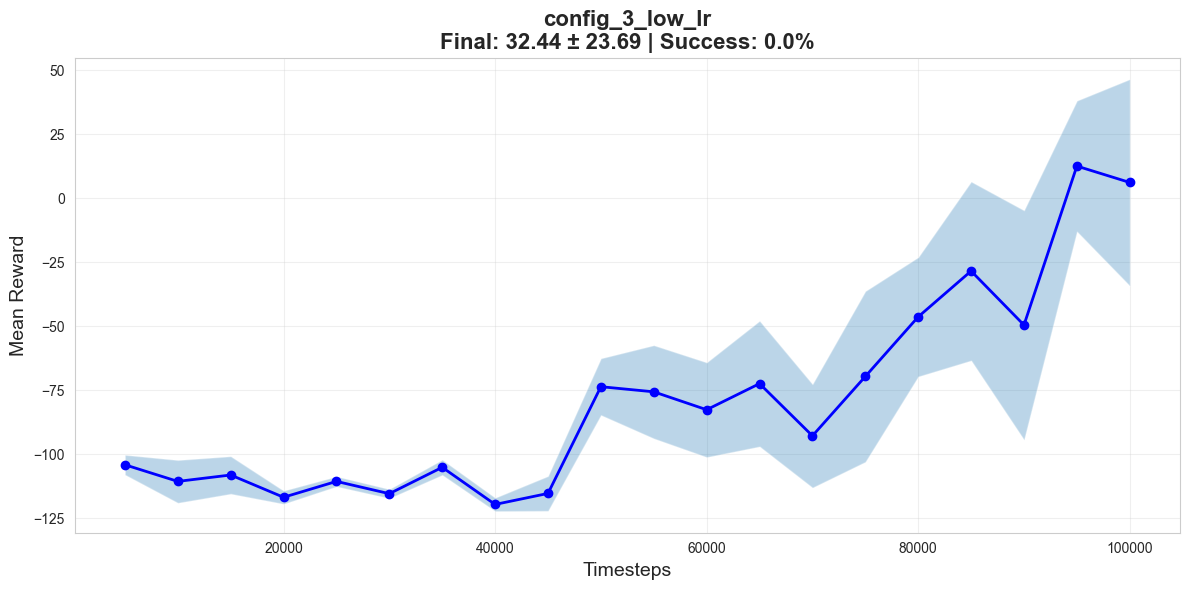


✅ RESULTS for config_3_low_lr:
   📈 Mean Reward: 32.44 ± 23.69
   🎯 Success Rate: 0.0%
   ⏱️  Training Time: 118.0s (2.0 min)
   💾 Saved to: models/ppo\config_3_low_lr


🔄 Progress: 4/11 configurations

🚀 Training: config_4_large_batch
📝 Large Batch - Stable gradients

📊 Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -76.99 ± 26.51

[Eval] Step  10000: Reward =  -12.19 ± 24.03

[Eval] Step  15000: Reward =   43.21 ± 14.48

[Eval] Step  20000: Reward =   43.11 ± 11.71

[Eval] Step  25000: Reward =   44.91 ±  7.67

[Eval] Step  30000: Reward =   49.11 ±  1.00

[Eval] Step  35000: Reward =   49.61 ±  0.40

[Eval] Step  40000: Reward =   49.51 ±  0.64

[Eval] Step  45000: Reward =   49.51 ±  0.46

[Eval] Step  50000: Reward =   48.71 ±  0.70

[Eval] Step  55000: Reward =   48.91 ±  1.04

[Eval] Step  60000: Reward =   49.51 ±  0.90

[Eval] Step  65000: Reward =   49.21 ±  0.80

[Eval] Step  70000: Reward =   48.71 ±  1.30

[Eval] Step  75000: Reward =   49.21 ±  0.66

[Eval] Step  80000: Reward =   49.31 ±  1.12

[Eval] Step  85000: Reward =   50.01 ±  0.75

[Eval] Step  90000: Reward =   49.71 ±  1.04

[Eval] Step  95000: Reward =   49.11 ±  0.64

[Eval] Step 100000: Reward =   49.71 ±  1.30


🧪 Final evaluation (100 episodes)...
🎯 Calculating success rate...


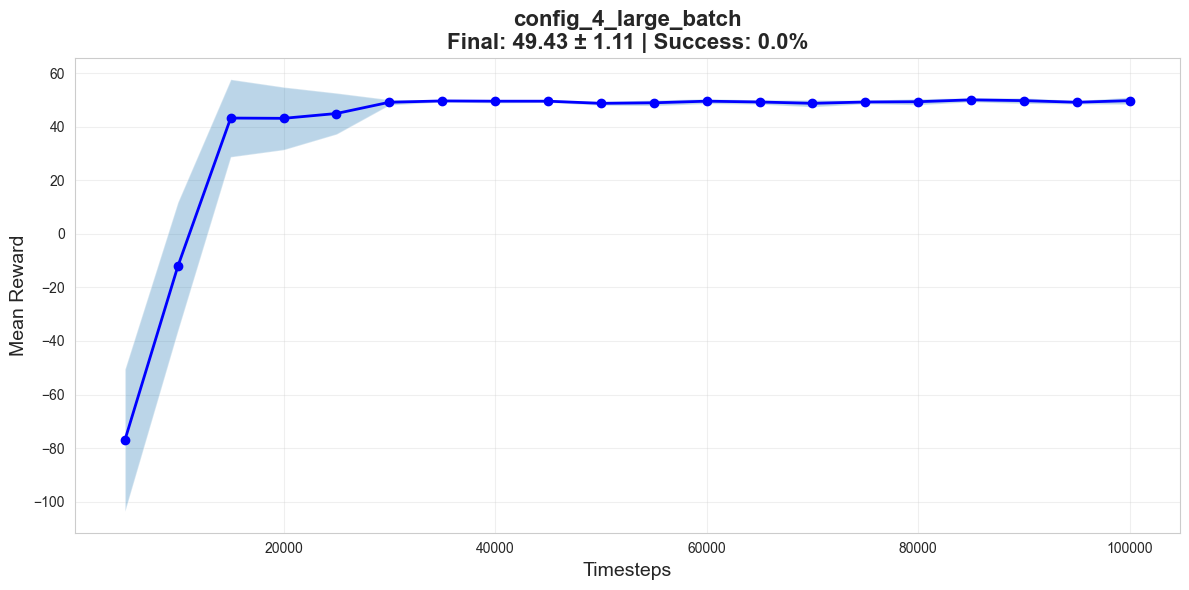


✅ RESULTS for config_4_large_batch:
   📈 Mean Reward: 49.43 ± 1.11
   🎯 Success Rate: 0.0%
   ⏱️  Training Time: 85.5s (1.4 min)
   💾 Saved to: models/ppo\config_4_large_batch


🔄 Progress: 5/11 configurations

🚀 Training: config_5_small_batch
📝 Small Batch - Fast updates

📊 Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -59.09 ± 69.76

[Eval] Step  10000: Reward =   32.31 ± 51.51

[Eval] Step  15000: Reward =   -7.49 ± 70.66

[Eval] Step  20000: Reward =   48.41 ±  3.32

[Eval] Step  25000: Reward =   50.21 ±  1.02

[Eval] Step  30000: Reward =   50.31 ±  2.11

[Eval] Step  35000: Reward =   43.31 ± 19.61

[Eval] Step  40000: Reward =   44.61 ± 15.19

[Eval] Step  45000: Reward =   50.91 ±  1.81

[Eval] Step  50000: Reward =   49.11 ±  2.87

[Eval] Step  55000: Reward =   50.41 ±  2.11

[Eval] Step  60000: Reward =   49.31 ±  2.25

[Eval] Step  65000: Reward =   49.41 ±  2.42

[Eval] Step  70000: Reward =   50.71 ±  2.12

[Eval] Step  75000: Reward =   50.71 ±  2.12

[Eval] Step  80000: Reward =   51.01 ±  2.52

[Eval] Step  85000: Reward =   51.61 ±  2.52

[Eval] Step  90000: Reward =   61.21 ± 24.20

[Eval] Step  95000: Reward =   78.61 ± 48.83

[Eval] Step 100000: Reward =   58.11 ± 52.71


🧪 Final evaluation (100 episodes)...
🎯 Calculating success rate...


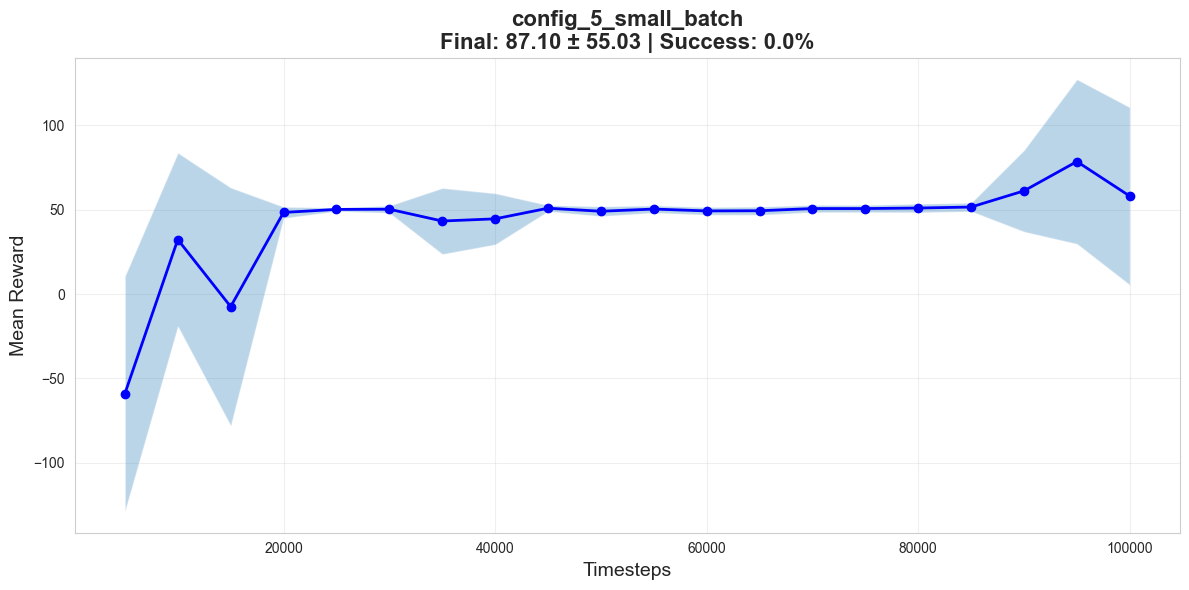


✅ RESULTS for config_5_small_batch:
   📈 Mean Reward: 87.10 ± 55.03
   🎯 Success Rate: 0.0%
   ⏱️  Training Time: 195.1s (3.3 min)
   💾 Saved to: models/ppo\config_5_small_batch


🔄 Progress: 6/11 configurations

🚀 Training: config_6_low_gamma
📝 Low Gamma - Compare with DQN config 6

📊 Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -54.59 ± 63.13

[Eval] Step  10000: Reward =  -45.29 ± 68.78

[Eval] Step  15000: Reward =  -26.79 ± 80.11

[Eval] Step  20000: Reward =   18.11 ± 56.16

[Eval] Step  25000: Reward =   43.31 ± 17.44

[Eval] Step  30000: Reward =   16.51 ± 52.16

[Eval] Step  35000: Reward =   37.41 ± 41.22

[Eval] Step  40000: Reward =   33.81 ± 45.70

[Eval] Step  45000: Reward =   84.71 ± 102.71

[Eval] Step  50000: Reward =  162.41 ± 107.18

[Eval] Step  55000: Reward =  161.81 ± 105.02

[Eval] Step  60000: Reward =  122.11 ± 157.56

[Eval] Step  65000: Reward =   69.81 ± 159.32

[Eval] Step  70000: Reward =  155.11 ± 136.68

[Eval] Step  75000: Reward =   85.11 ± 167.64

[Eval] Step  80000: Reward =  193.01 ± 103.49

[Eval] Step  85000: Reward =  191.61 ± 103.79

[Eval] Step  90000: Reward =  121.81 ± 156.50

[Eval] Step  95000: Reward =  169.31 ± 107.25

[Eval] Step 100000: Reward =  191.31 ± 102.36


🧪 Final evaluation (100 episodes)...
🎯 Calculating success rate...


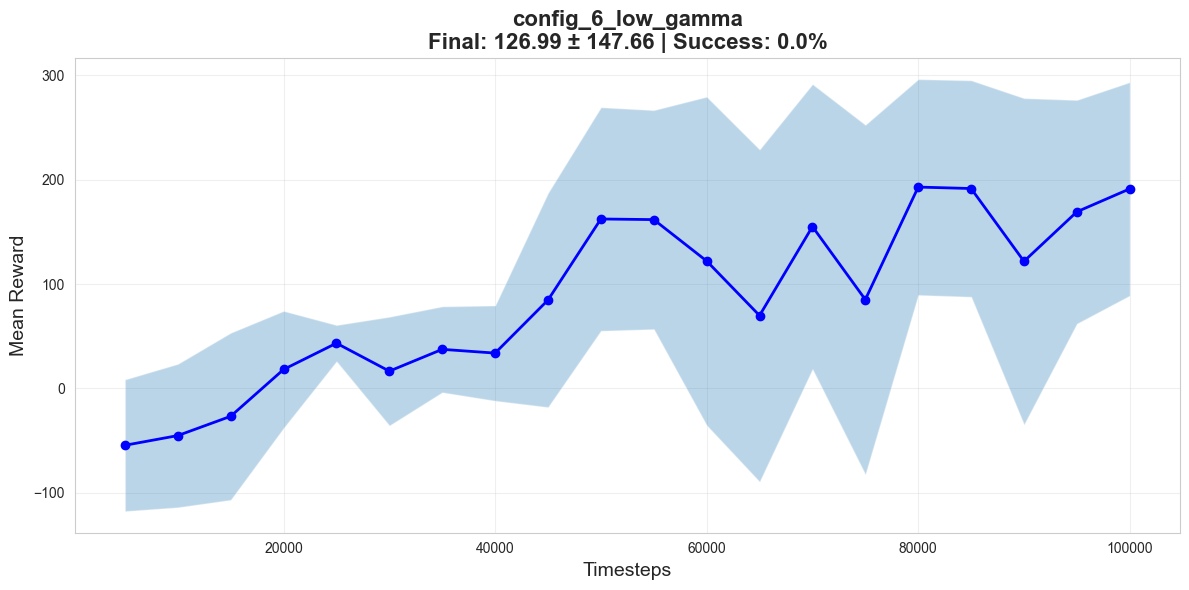


✅ RESULTS for config_6_low_gamma:
   📈 Mean Reward: 126.99 ± 147.66
   🎯 Success Rate: 0.0%
   ⏱️  Training Time: 118.3s (2.0 min)
   💾 Saved to: models/ppo\config_6_low_gamma


🔄 Progress: 7/11 configurations

🚀 Training: config_7_high_gamma
📝 High Gamma - Compare with DQN config 7

📊 Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -85.39 ± 47.14

[Eval] Step  10000: Reward =    4.31 ± 69.07

[Eval] Step  15000: Reward =   26.91 ± 30.73

[Eval] Step  20000: Reward =  -34.39 ± 86.02

[Eval] Step  25000: Reward =   42.01 ± 22.12

[Eval] Step  30000: Reward =   38.01 ± 33.51

[Eval] Step  35000: Reward =   44.01 ± 10.57

[Eval] Step  40000: Reward =   50.41 ±  1.74

[Eval] Step  45000: Reward =   49.61 ±  1.17

[Eval] Step  50000: Reward =   49.71 ±  1.30

[Eval] Step  55000: Reward =   50.41 ±  0.80

[Eval] Step  60000: Reward =   49.21 ±  1.56

[Eval] Step  65000: Reward =   49.51 ±  1.35

[Eval] Step  70000: Reward =   49.51 ±  1.19

[Eval] Step  75000: Reward =   49.41 ±  1.20

[Eval] Step  80000: Reward =   49.41 ±  1.43

[Eval] Step  85000: Reward =   49.11 ±  1.49

[Eval] Step  90000: Reward =   49.51 ±  1.35

[Eval] Step  95000: Reward =   49.51 ±  1.27

[Eval] Step 100000: Reward =   49.91 ±  1.04


🧪 Final evaluation (100 episodes)...
🎯 Calculating success rate...


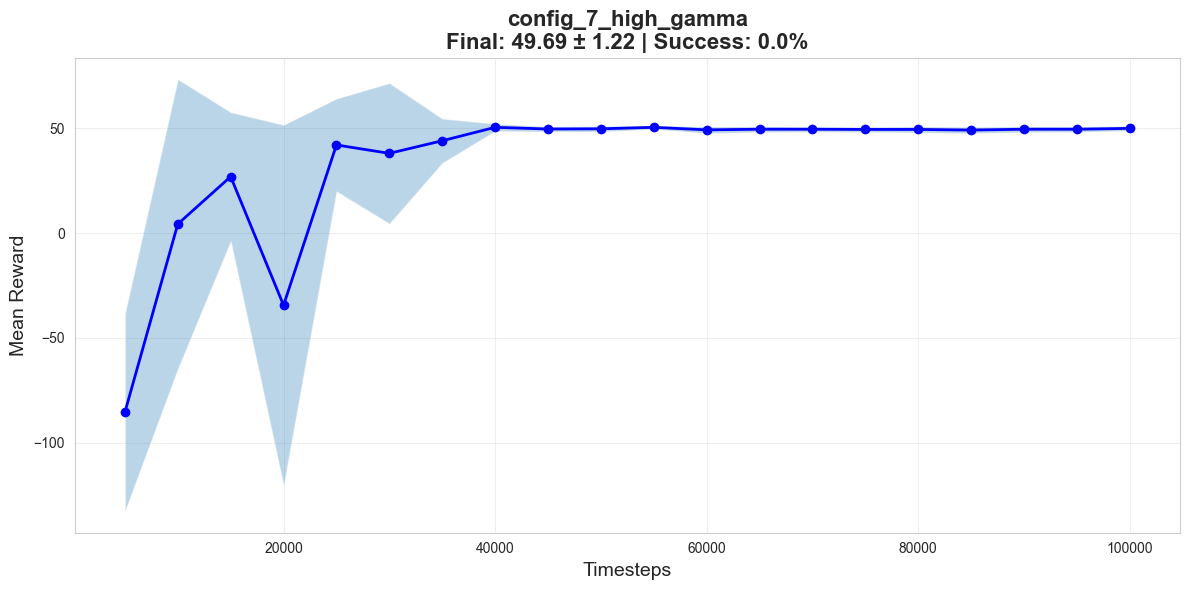


✅ RESULTS for config_7_high_gamma:
   📈 Mean Reward: 49.69 ± 1.22
   🎯 Success Rate: 0.0%
   ⏱️  Training Time: 171.4s (2.9 min)
   💾 Saved to: models/ppo\config_7_high_gamma


🔄 Progress: 8/11 configurations

🚀 Training: config_8_high_entropy
📝 High Entropy - More exploration

📊 Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward = -114.79 ±  5.57

[Eval] Step  10000: Reward =   19.31 ± 47.36

[Eval] Step  15000: Reward =   49.11 ±  1.27

[Eval] Step  20000: Reward =   -3.19 ± 70.71

[Eval] Step  25000: Reward =  -13.79 ± 75.61

[Eval] Step  30000: Reward =   38.41 ± 25.28

[Eval] Step  35000: Reward =   16.21 ± 67.71

[Eval] Step  40000: Reward =   12.31 ± 96.67

[Eval] Step  45000: Reward =   89.11 ± 50.55

[Eval] Step  50000: Reward =  149.21 ± 134.29

[Eval] Step  55000: Reward =  114.61 ± 147.99

[Eval] Step  60000: Reward =   67.31 ± 155.71

[Eval] Step  65000: Reward =  183.66 ± 68.20

[Eval] Step  70000: Reward =   60.71 ± 123.91

[Eval] Step  75000: Reward =  141.66 ± 106.87

[Eval] Step  80000: Reward =   46.46 ± 145.25

[Eval] Step  85000: Reward =   64.51 ± 151.49

[Eval] Step  90000: Reward =   47.81 ± 110.69

[Eval] Step  95000: Reward =  -17.59 ± 154.34

[Eval] Step 100000: Reward =  185.01 ± 102.13


🧪 Final evaluation (100 episodes)...
🎯 Calculating success rate...


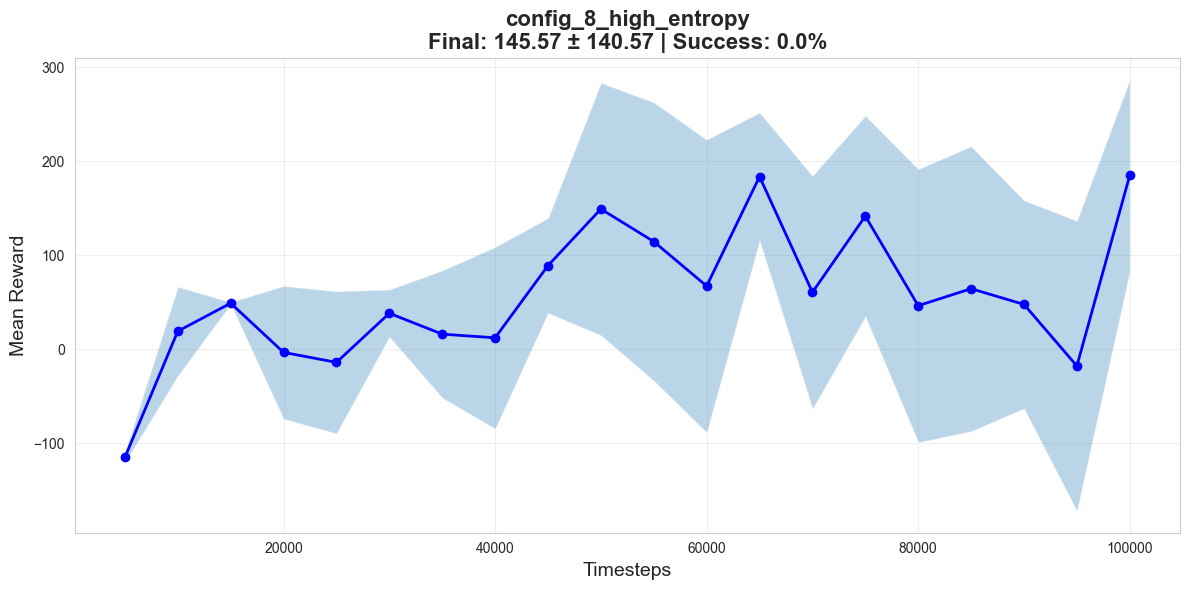


✅ RESULTS for config_8_high_entropy:
   📈 Mean Reward: 145.57 ± 140.57
   🎯 Success Rate: 0.0%
   ⏱️  Training Time: 148.6s (2.5 min)
   💾 Saved to: models/ppo\config_8_high_entropy


🔄 Progress: 9/11 configurations

🚀 Training: config_9_low_entropy
📝 Low Entropy - Pure exploitation

📊 Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -74.39 ± 42.12

[Eval] Step  10000: Reward =  -61.29 ± 49.22

[Eval] Step  15000: Reward =  -78.09 ± 63.13

[Eval] Step  20000: Reward =  -27.19 ± 80.61

[Eval] Step  25000: Reward =  -16.19 ± 81.87

[Eval] Step  30000: Reward =   31.21 ± 46.96

[Eval] Step  35000: Reward =   47.31 ±  9.94

[Eval] Step  40000: Reward =   46.81 ±  9.07

[Eval] Step  45000: Reward =   49.21 ±  5.46

[Eval] Step  50000: Reward =   49.31 ±  1.02

[Eval] Step  55000: Reward =   49.91 ±  1.22

[Eval] Step  60000: Reward =   50.01 ±  1.08

[Eval] Step  65000: Reward =   49.41 ±  1.28

[Eval] Step  70000: Reward =   49.31 ±  0.81

[Eval] Step  75000: Reward =   49.41 ±  1.02

[Eval] Step  80000: Reward =   49.91 ±  1.04

[Eval] Step  85000: Reward =   50.11 ±  3.13

[Eval] Step  90000: Reward =   49.91 ±  0.83

[Eval] Step  95000: Reward =   49.61 ±  1.33

[Eval] Step 100000: Reward =   51.31 ±  8.00


🧪 Final evaluation (100 episodes)...
🎯 Calculating success rate...


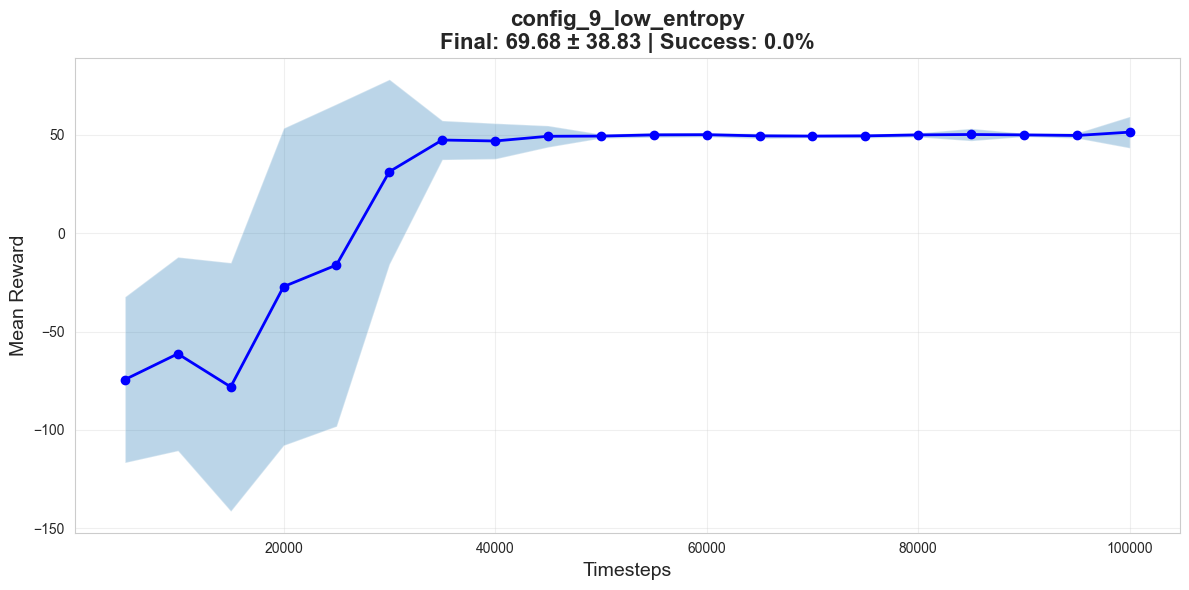


✅ RESULTS for config_9_low_entropy:
   📈 Mean Reward: 69.68 ± 38.83
   🎯 Success Rate: 0.0%
   ⏱️  Training Time: 131.7s (2.2 min)
   💾 Saved to: models/ppo\config_9_low_entropy


🔄 Progress: 10/11 configurations

🚀 Training: config_10_optimized
📝 Optimized - Best guess for task

📊 Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward = -101.39 ± 21.80

[Eval] Step  10000: Reward =   48.51 ±  1.49

[Eval] Step  15000: Reward =   -1.59 ± 78.30

[Eval] Step  20000: Reward =   45.81 ±  8.38

[Eval] Step  25000: Reward =   40.91 ± 27.38

[Eval] Step  30000: Reward =   24.91 ± 47.67

[Eval] Step  35000: Reward =   21.21 ± 56.49

[Eval] Step  40000: Reward =   20.61 ± 53.92

[Eval] Step  45000: Reward =   28.31 ± 50.36

[Eval] Step  50000: Reward =    1.61 ± 69.41

[Eval] Step  55000: Reward =   16.01 ± 67.61

[Eval] Step  60000: Reward =  -12.59 ± 77.16

[Eval] Step  65000: Reward =   -2.29 ± 68.02

[Eval] Step  70000: Reward =  -32.39 ± 83.27

[Eval] Step  75000: Reward =  -49.89 ± 72.24

[Eval] Step  80000: Reward =    0.81 ± 73.65

[Eval] Step  85000: Reward =  -26.59 ± 87.59

[Eval] Step  90000: Reward =  -12.79 ± 130.85

[Eval] Step  95000: Reward =   25.51 ± 118.13

[Eval] Step 100000: Reward =  -14.99 ± 104.74


🧪 Final evaluation (100 episodes)...
🎯 Calculating success rate...


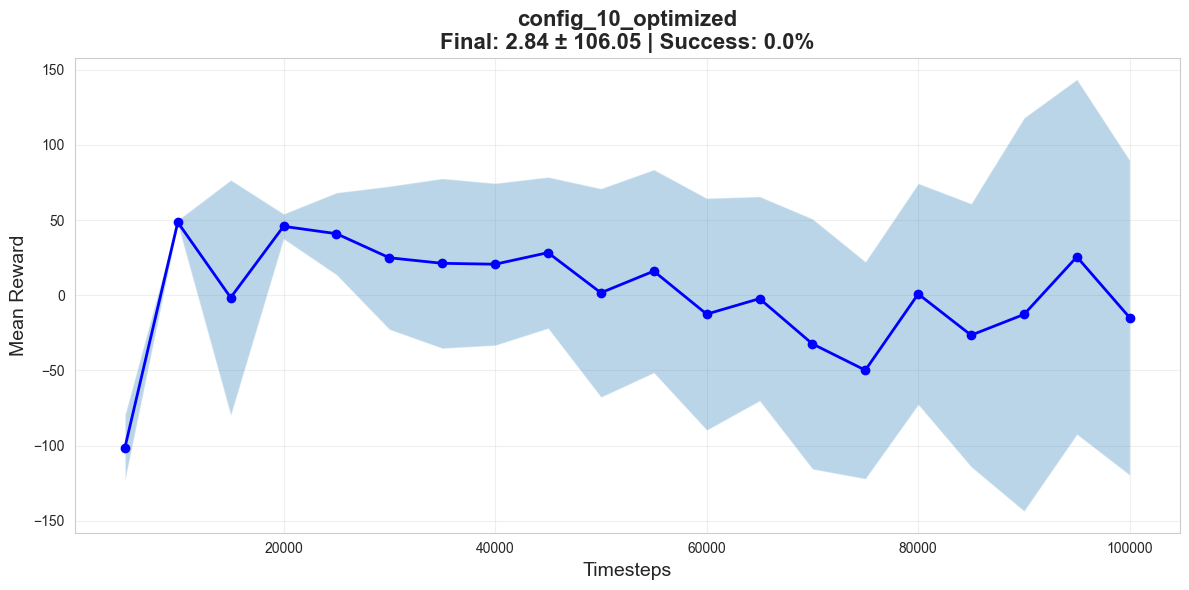


✅ RESULTS for config_10_optimized:
   📈 Mean Reward: 2.84 ± 106.05
   🎯 Success Rate: 0.0%
   ⏱️  Training Time: 118.6s (2.0 min)
   💾 Saved to: models/ppo\config_10_optimized


🔄 Progress: 11/11 configurations

🚀 Training: config_11_many_epochs
📝 Many Epochs - Sample efficient

📊 Creating PPO model...
🎓 Training for 100,000 timesteps...



[Eval] Step   5000: Reward =  -18.99 ± 64.03

[Eval] Step  10000: Reward =    0.51 ± 62.83

[Eval] Step  15000: Reward =   -2.79 ± 73.82

[Eval] Step  20000: Reward =   15.81 ± 69.53

[Eval] Step  25000: Reward =   49.81 ±  0.77

[Eval] Step  30000: Reward =   50.21 ±  1.20

[Eval] Step  35000: Reward =   38.11 ± 30.85

[Eval] Step  40000: Reward =   57.01 ± 106.84

[Eval] Step  45000: Reward =  144.21 ± 80.35

[Eval] Step  50000: Reward =  118.41 ± 136.45

[Eval] Step  55000: Reward =   85.91 ± 100.89

[Eval] Step  60000: Reward =  102.91 ± 133.73

[Eval] Step  65000: Reward =   25.81 ± 162.18

[Eval] Step  70000: Reward =  110.51 ± 144.59

[Eval] Step  75000: Reward =  157.41 ± 136.90

[Eval] Step  80000: Reward =  172.41 ± 101.16

[Eval] Step  85000: Reward =  131.21 ± 130.85

[Eval] Step  90000: Reward =  120.31 ± 135.49

[Eval] Step  95000: Reward =   18.11 ± 168.39

[Eval] Step 100000: Reward =   82.61 ± 164.28


🧪 Final evaluation (100 episodes)...
🎯 Calculating success rate...


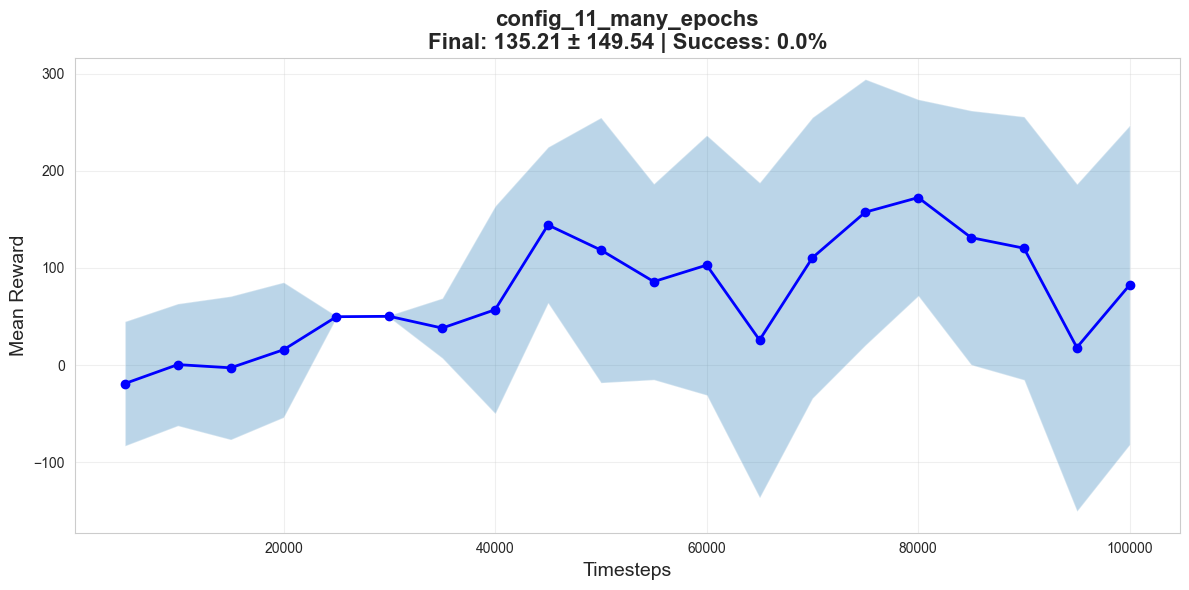


✅ RESULTS for config_11_many_epochs:
   📈 Mean Reward: 135.21 ± 149.54
   🎯 Success Rate: 0.0%
   ⏱️  Training Time: 188.6s (3.1 min)
   💾 Saved to: models/ppo\config_11_many_epochs


✅ ALL TRAINING COMPLETE!
   Trained 11/11 configurations successfully


In [6]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 6: TRAIN ALL CONFIGURATIONS
# ═══════════════════════════════════════════════════════════════════════
"""
🚨 MAIN TRAINING CELL - This will take a while!

Adjust total_timesteps based on your time:
- 50k = ~30-60 min total (quick test)
- 100k = ~1-2 hours total (recommended)
- 200k = ~2-4 hours total (better results)

You can also train individual configs by commenting out others
"""

# CONFIGURATION
TOTAL_TIMESTEPS = 100000  # Adjust this based on your compute time

print("\n" + "="*80)
print("🎯 PPO HYPERPARAMETER TUNING - FIRE RESCUE ENVIRONMENT")
print("="*80)
print(f"\n📊 Total Configs: {len(PPO_CONFIGS)}")
print(f"⏱️  Timesteps per config: {TOTAL_TIMESTEPS:,}")
print(f"📈 Total training timesteps: {TOTAL_TIMESTEPS * len(PPO_CONFIGS):,}")
print(f"\n⚠️  This will take approximately {(TOTAL_TIMESTEPS * len(PPO_CONFIGS)) / 50000:.1f} hours")
print(f"    (Estimate: ~{TOTAL_TIMESTEPS / 50000 * 5:.0f} min per config)")
print("\n" + "="*80 + "\n")

# Train all configurations
all_results = []

for i, (config_name, config) in enumerate(PPO_CONFIGS.items(), 1):
    print(f"\n🔄 Progress: {i}/{len(PPO_CONFIGS)} configurations")
    
    try:
        results = train_ppo_config(config_name, config, TOTAL_TIMESTEPS)
        all_results.append(results)
    except Exception as e:
        print(f"❌ ERROR training {config_name}: {e}")
        import traceback
        traceback.print_exc()
        continue

print("\n" + "="*80)
print("✅ ALL TRAINING COMPLETE!")
print(f"   Trained {len(all_results)}/{len(PPO_CONFIGS)} configurations successfully")
print("="*80)

In [7]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 7: GENERATE COMPARISON REPORT
# ═══════════════════════════════════════════════════════════════════════
"""
Create comprehensive comparison visualizations and summary
"""

if len(all_results) == 0:
    print("❌ No results to compare!")
else:
    # Sort by mean reward
    results_sorted = sorted(all_results, key=lambda x: x['mean_reward'], reverse=True)
    
    # Create comparison directory
    comp_dir = "models/ppo/comparison"
    os.makedirs(comp_dir, exist_ok=True)
    
    # Print summary table
    print("\n" + "="*100)
    print("📊 PPO TRAINING RESULTS SUMMARY (Sorted by Mean Reward)")
    print("="*100)
    print(f"{'Rank':<6} {'Config':<30} {'Mean Reward':<20} {'Success Rate':<15} {'Time (min)':<12}")
    print("="*100)
    
    for rank, result in enumerate(results_sorted, 1):
        emoji = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
        print(f"{emoji} {rank:<4} {result['config_name']:<30} "
              f"{result['mean_reward']:>7.2f} ± {result['std_reward']:<8.2f} "
              f"{result['success_rate']:>13.1%} "
              f"{result['training_time']/60:>12.1f}")
    print("="*100)
    
    # Save detailed results
    with open(os.path.join(comp_dir, "all_results.json"), 'w') as f:
        json.dump(results_sorted, f, indent=4)
    
    print(f"\n💾 Detailed results saved to: {comp_dir}/all_results.json")


📊 PPO TRAINING RESULTS SUMMARY (Sorted by Mean Reward)
Rank   Config                         Mean Reward          Success Rate    Time (min)  
🥇 1    config_8_high_entropy           145.57 ± 140.57            0.0%          2.5
🥈 2    config_11_many_epochs           135.21 ± 149.54            0.0%          3.1
🥉 3    config_6_low_gamma              126.99 ± 147.66            0.0%          2.0
   4    config_5_small_batch             87.10 ± 55.03             0.0%          3.3
   5    config_9_low_entropy             69.68 ± 38.83             0.0%          2.2
   6    config_7_high_gamma              49.69 ± 1.22              0.0%          2.9
   7    config_1_baseline                49.54 ± 1.43              0.0%          2.0
   8    config_4_large_batch             49.43 ± 1.11              0.0%          1.4
   9    config_3_low_lr                  32.44 ± 23.69             0.0%          2.0
   10   config_2_high_lr                  6.74 ± 60.09             0.0%          2.2
   11   c

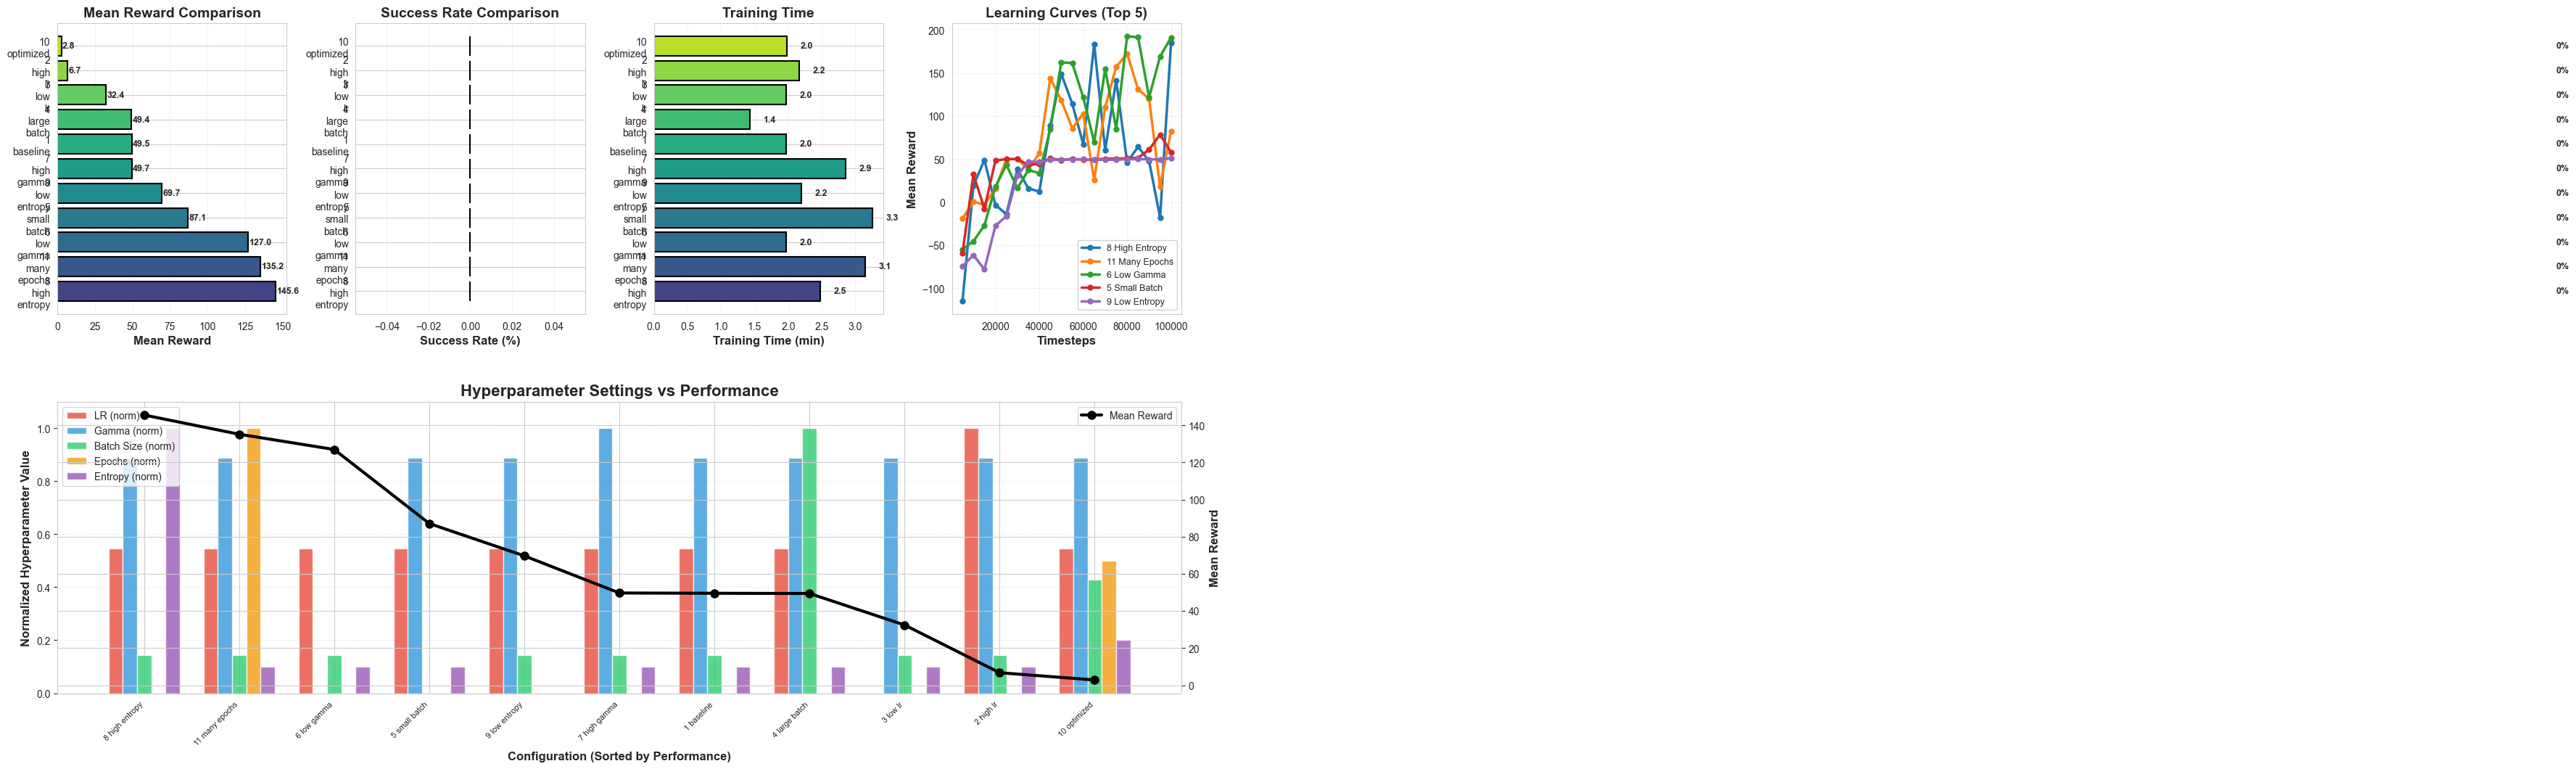


Comprehensive analysis plot saved to: models/ppo/comparison/ppo_comprehensive_analysis.png


In [8]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 8: COMPREHENSIVE VISUALIZATION (Combines old Cell 8 + 15)
# ═══════════════════════════════════════════════════════════════════════
"""
Create all comparison visualizations in one comprehensive figure
"""

if len(all_results) > 0:
    # Create large figure with 2 rows: 4 plots top, 1 large plot bottom
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 4, height_ratios=[1, 1], hspace=0.3, wspace=0.3)
    
    # Prepare data
    results_sorted = sorted(all_results, key=lambda x: x['mean_reward'], reverse=True)
    configs = [r['config_name'].replace('config_', '').replace('_', '\n') 
               for r in results_sorted]
    rewards = [r['mean_reward'] for r in results_sorted]
    success_rates = [r['success_rate'] * 100 for r in results_sorted]
    times = [r['training_time'] / 60 for r in results_sorted]
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(configs)))
    
    # ─────────────────────────────────────────────────────────────────────
    # TOP ROW: 4 comparison plots
    # ─────────────────────────────────────────────────────────────────────
    
    # Plot 1: Mean Rewards
    ax1 = fig.add_subplot(gs[0, 0])
    bars1 = ax1.barh(configs, rewards, color=colors, edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Mean Reward', fontsize=12, fontweight='bold')
    ax1.set_title('Mean Reward Comparison', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    for bar, val in zip(bars1, rewards):
        ax1.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}', 
                va='center', fontsize=9, fontweight='bold')
    
    # Plot 2: Success Rates
    ax2 = fig.add_subplot(gs[0, 1])
    bars2 = ax2.barh(configs, success_rates, color=colors, edgecolor='black', linewidth=1.5)
    ax2.set_xlabel('Success Rate (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Success Rate Comparison', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    for bar, val in zip(bars2, success_rates):
        ax2.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.0f}%', 
                va='center', fontsize=9, fontweight='bold')
    
    # Plot 3: Training Time
    ax3 = fig.add_subplot(gs[0, 2])
    bars3 = ax3.barh(configs, times, color=colors, edgecolor='black', linewidth=1.5)
    ax3.set_xlabel('Training Time (min)', fontsize=12, fontweight='bold')
    ax3.set_title('Training Time', fontsize=14, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3, linestyle='--')
    for bar, val in zip(bars3, times):
        ax3.text(val + 0.2, bar.get_y() + bar.get_height()/2, f'{val:.1f}', 
                va='center', fontsize=9, fontweight='bold')
    
    # Plot 4: Learning Curves (Top 5)
    ax4 = fig.add_subplot(gs[0, 3])
    for i, result in enumerate(results_sorted[:5]):
        if 'eval_timesteps' in result and len(result['eval_timesteps']) > 0:
            label = result['config_name'].replace('config_', '').replace('_', ' ').title()
            ax4.plot(result['eval_timesteps'], result['eval_rewards'], 
                    label=label, linewidth=2.5, marker='o', markersize=5)
    ax4.set_xlabel('Timesteps', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Mean Reward', fontsize=12, fontweight='bold')
    ax4.set_title('Learning Curves (Top 5)', fontsize=14, fontweight='bold')
    ax4.legend(loc='best', fontsize=9, framealpha=0.9)
    ax4.grid(True, alpha=0.3, linestyle='--')
    
    # ─────────────────────────────────────────────────────────────────────
    # BOTTOM ROW: Hyperparameter correlation heatmap
    # ─────────────────────────────────────────────────────────────────────
    
    ax5 = fig.add_subplot(gs[1, :])
    
    # Extract hyperparameters and performance
    lrs = [r['config']['learning_rate'] for r in results_sorted]
    gammas = [r['config']['gamma'] for r in results_sorted]
    batches = [r['config']['batch_size'] for r in results_sorted]
    n_steps = [r['config']['n_steps'] for r in results_sorted]
    n_epochs = [r['config']['n_epochs'] for r in results_sorted]
    ent_coefs = [r['config']['ent_coef'] for r in results_sorted]
    rewards_sorted = [r['mean_reward'] for r in results_sorted]
    
    # Create positions for grouped bars
    x = np.arange(len(results_sorted))
    width = 0.15
    
    # Normalize values to 0-1 for comparison
    norm_lrs = [(np.log10(lr) - np.log10(min(lrs))) / (np.log10(max(lrs)) - np.log10(min(lrs))) if max(lrs) != min(lrs) else 0.5 for lr in lrs]
    norm_gammas = [(g - min(gammas)) / (max(gammas) - min(gammas)) if max(gammas) != min(gammas) else 0.5 for g in gammas]
    norm_batches = [(b - min(batches)) / (max(batches) - min(batches)) if max(batches) != min(batches) else 0.5 for b in batches]
    norm_epochs = [(e - min(n_epochs)) / (max(n_epochs) - min(n_epochs)) if max(n_epochs) != min(n_epochs) else 0.5 for e in n_epochs]
    norm_ent = [(e - min(ent_coefs)) / (max(ent_coefs) - min(ent_coefs)) if max(ent_coefs) != min(ent_coefs) else 0.5 for e in ent_coefs]
    
    # Plot grouped bars
    ax5.bar(x - 2*width, norm_lrs, width, label='LR (norm)', alpha=0.8, color='#e74c3c')
    ax5.bar(x - width, norm_gammas, width, label='Gamma (norm)', alpha=0.8, color='#3498db')
    ax5.bar(x, norm_batches, width, label='Batch Size (norm)', alpha=0.8, color='#2ecc71')
    ax5.bar(x + width, norm_epochs, width, label='Epochs (norm)', alpha=0.8, color='#f39c12')
    ax5.bar(x + 2*width, norm_ent, width, label='Entropy (norm)', alpha=0.8, color='#9b59b6')
    
    # Overlay performance as line
    ax5_twin = ax5.twinx()
    ax5_twin.plot(x, rewards_sorted, 'ko-', linewidth=3, markersize=8, label='Mean Reward')
    ax5_twin.set_ylabel('Mean Reward', fontsize=12, fontweight='bold')
    
    # Formatting
    ax5.set_xlabel('Configuration (Sorted by Performance)', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Normalized Hyperparameter Value', fontsize=12, fontweight='bold')
    ax5.set_title('Hyperparameter Settings vs Performance', fontsize=16, fontweight='bold')
    ax5.set_xticks(x)
    ax5.set_xticklabels([c.replace('\n', ' ') for c in configs], rotation=45, ha='right', fontsize=8)
    ax5.legend(loc='upper left', fontsize=10)
    ax5_twin.legend(loc='upper right', fontsize=10)
    ax5.grid(axis='y', alpha=0.3, linestyle='--')
    ax5.set_ylim(0, 1.1)
    
    plt.tight_layout()
    plt.savefig('models/ppo/comparison/ppo_comprehensive_analysis.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    print(f"\nComprehensive analysis plot saved to: models/ppo/comparison/ppo_comprehensive_analysis.png")


🏆 BEST PERFORMING CONFIGURATION

📛 Config: config_8_high_entropy
📝 Description: High Entropy - More exploration

📊 PERFORMANCE METRICS:
   🎯 Mean Reward: 145.57 ± 140.57
   ✅ Success Rate: 0.0%
   ⏱️  Training Time: 2.5 minutes

⚙️  HYPERPARAMETERS:
   • Learning Rate: 3e-04
   • Gamma: 0.99
   • Batch Size: 64
   • N Steps: 2048
   • N Epochs: 10
   • Clip Range: 0.2
   • GAE Lambda: 0.95
   • Entropy Coef: 0.1
   • Network: [64, 64]

💾 Model saved at:
   models/ppo/config_8_high_entropy/final_model.zip


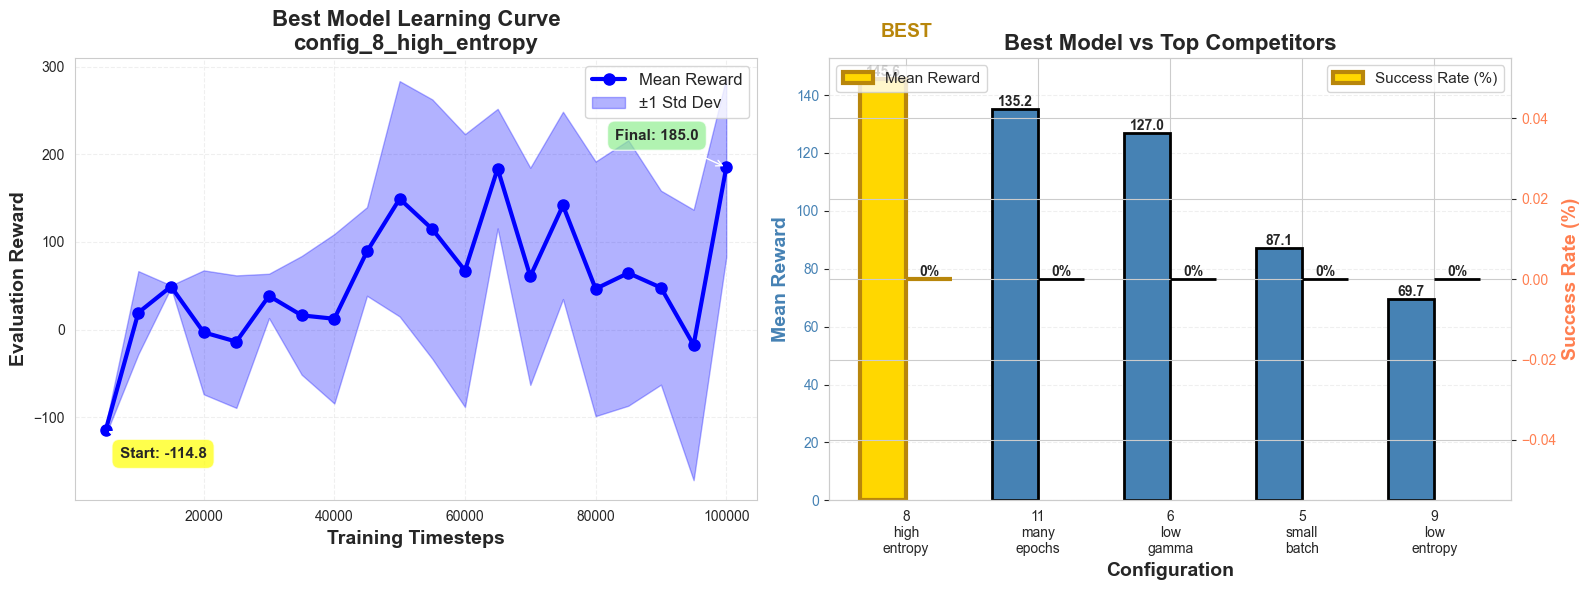


Best model plots saved to: models/ppo/config_8_high_entropy/best_model_analysis.png

Use this model for your video demonstration!


In [9]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 9: BEST MODEL SUMMARY WITH VISUALIZATIONS
# ═══════════════════════════════════════════════════════════════════════
"""
Detailed summary of best model with dedicated visualizations
"""

if len(all_results) > 0:
    results_sorted = sorted(all_results, key=lambda x: x['mean_reward'], reverse=True)
    best = results_sorted[0]
    
    print("\n" + "="*80)
    print("🏆 BEST PERFORMING CONFIGURATION")
    print("="*80)
    print(f"\n📛 Config: {best['config_name']}")
    print(f"📝 Description: {best['config']['description']}")
    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"   🎯 Mean Reward: {best['mean_reward']:.2f} ± {best['std_reward']:.2f}")
    print(f"   ✅ Success Rate: {best['success_rate']:.1%}")
    print(f"   ⏱️  Training Time: {best['training_time']/60:.1f} minutes")
    
    print(f"\n⚙️  HYPERPARAMETERS:")
    print(f"   • Learning Rate: {best['config']['learning_rate']:.0e}")
    print(f"   • Gamma: {best['config']['gamma']}")
    print(f"   • Batch Size: {best['config']['batch_size']}")
    print(f"   • N Steps: {best['config']['n_steps']}")
    print(f"   • N Epochs: {best['config']['n_epochs']}")
    print(f"   • Clip Range: {best['config']['clip_range']}")
    print(f"   • GAE Lambda: {best['config']['gae_lambda']}")
    print(f"   • Entropy Coef: {best['config']['ent_coef']}")
    print(f"   • Network: {best['config']['policy_kwargs']['net_arch']}")
    
    print(f"\n💾 Model saved at:")
    print(f"   models/ppo/{best['config_name']}/final_model.zip")
    print("="*80)
    
    # ─────────────────────────────────────────────────────────────────────
    # Create dedicated plots for best model
    # ─────────────────────────────────────────────────────────────────────
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Learning Curve with Confidence Interval
    ax1 = axes[0]
    if 'eval_timesteps' in best and len(best['eval_timesteps']) > 0:
        timesteps = best['eval_timesteps']
        rewards = best['eval_rewards']
        stds = best['eval_stds']
        
        ax1.plot(timesteps, rewards, 'b-', linewidth=3, marker='o', markersize=8, 
                label='Mean Reward')
        ax1.fill_between(timesteps, 
                        np.array(rewards) - np.array(stds),
                        np.array(rewards) + np.array(stds),
                        alpha=0.3, color='blue', label='±1 Std Dev')
        
        ax1.set_xlabel('Training Timesteps', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Evaluation Reward', fontsize=14, fontweight='bold')
        ax1.set_title(f'Best Model Learning Curve\n{best["config_name"]}', 
                     fontsize=16, fontweight='bold')
        ax1.legend(fontsize=12, loc='best')
        ax1.grid(True, alpha=0.3, linestyle='--')
        
        # Add annotations for first and last points
        ax1.annotate(f'Start: {rewards[0]:.1f}', 
                    xy=(timesteps[0], rewards[0]),
                    xytext=(10, -20), textcoords='offset points',
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
        
        ax1.annotate(f'Final: {rewards[-1]:.1f}', 
                    xy=(timesteps[-1], rewards[-1]),
                    xytext=(-80, 20), textcoords='offset points',
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # Plot 2: Performance Comparison (Best vs Others)
    ax2 = axes[1]
    
    # Top 5 configs for comparison
    top5 = results_sorted[:5]
    config_names = [r['config_name'].replace('config_', '').replace('_', '\n') for r in top5]
    mean_rewards = [r['mean_reward'] for r in top5]
    success_rates = [r['success_rate'] * 100 for r in top5]
    
    x = np.arange(len(config_names))
    width = 0.35
    
    # Create bars
    bars1 = ax2.bar(x - width/2, mean_rewards, width, label='Mean Reward', 
                    color='steelblue', edgecolor='black', linewidth=2)
    
    # Create twin axis for success rate
    ax2_twin = ax2.twinx()
    bars2 = ax2_twin.bar(x + width/2, success_rates, width, label='Success Rate (%)', 
                        color='coral', edgecolor='black', linewidth=2)
    
    # Highlight best model
    bars1[0].set_color('gold')
    bars1[0].set_edgecolor('darkgoldenrod')
    bars1[0].set_linewidth(3)
    bars2[0].set_color('gold')
    bars2[0].set_edgecolor('darkgoldenrod')
    bars2[0].set_linewidth(3)
    
    # Add value labels
    for bar, val in zip(bars1, mean_rewards):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    for bar, val in zip(bars2, success_rates):
        height = bar.get_height()
        ax2_twin.text(bar.get_x() + bar.get_width()/2., height,
                     f'{val:.0f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Formatting
    ax2.set_xlabel('Configuration', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Mean Reward', fontsize=14, fontweight='bold', color='steelblue')
    ax2_twin.set_ylabel('Success Rate (%)', fontsize=14, fontweight='bold', color='coral')
    ax2.set_title('Best Model vs Top Competitors', fontsize=16, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(config_names, fontsize=10)
    ax2.legend(loc='upper left', fontsize=11)
    ax2_twin.legend(loc='upper right', fontsize=11)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.tick_params(axis='y', labelcolor='steelblue')
    ax2_twin.tick_params(axis='y', labelcolor='coral')
    
    # Add crown emoji annotation for best model
    ax2.text(0, max(mean_rewards) * 1.1, 'BEST', ha='center', fontsize=14, 
            fontweight='bold', color='darkgoldenrod')
    
    plt.tight_layout()
    plt.savefig(f'models/ppo/{best["config_name"]}/best_model_analysis.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    print(f"\nBest model plots saved to: models/ppo/{best['config_name']}/best_model_analysis.png")
    print(f"\nUse this model for your video demonstration!")

In [10]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 10: LOAD AND TEST BEST MODEL
# ═══════════════════════════════════════════════════════════════════════
"""
Load the best model and run a test episode
This shows you how to use the trained model
"""

if len(all_results) > 0:
    print("\n" + "="*80)
    print("🎮 TESTING BEST MODEL")
    print("="*80)
    
    # Load best model
    best_config = results_sorted[0]['config_name']
    model_path = f"models/ppo/{best_config}/final_model"
    
    print(f"\n📂 Loading model from: {model_path}")
    best_model = PPO.load(model_path)
    
    # Create test environment
    test_env = FireRescueEnv()
    
    print(f"🎯 Running 5 test episodes...\n")
    
    for episode in range(5):
        obs, _ = test_env.reset()
        total_reward = 0
        steps = 0
        done = False
        success = False
        
        while not done:
            action, _ = best_model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = test_env.step(action)
            total_reward += reward
            steps += 1
            done = terminated or truncated
            
            if info.get('success', False):
                success = True
        
        status = "✅ SUCCESS" if success else "❌ FAILED"
        print(f"   Episode {episode+1}: {status} | Reward: {total_reward:>7.2f} | Steps: {steps}")
    
    test_env.close()
    print("\n" + "="*80)


🎮 TESTING BEST MODEL

📂 Loading model from: models/ppo/config_8_high_entropy/final_model
🎯 Running 5 test episodes...

   Episode 1: ❌ FAILED | Reward:  229.81 | Steps: 120
   Episode 2: ❌ FAILED | Reward:  219.81 | Steps: 120
   Episode 3: ❌ FAILED | Reward: -121.19 | Steps: 120
   Episode 4: ❌ FAILED | Reward: -121.19 | Steps: 120
   Episode 5: ❌ FAILED | Reward:  230.81 | Steps: 120



In [11]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 11: HYPERPARAMETER ANALYSIS
# ═══════════════════════════════════════════════════════════════════════
"""
Analyze the impact of different hyperparameters
"""

if len(all_results) > 0:
    print("\n" + "="*80)
    print("🔬 HYPERPARAMETER IMPACT ANALYSIS")
    print("="*80)
    
    # Group results by hyperparameter variations
    
    # 1. Learning Rate Analysis
    print("\n📊 LEARNING RATE IMPACT:")
    print("-" * 60)
    lr_configs = ['config_2_high_lr', 'config_1_baseline', 'config_3_low_lr']
    for config_name in lr_configs:
        result = next((r for r in all_results if r['config_name'] == config_name), None)
        if result:
            lr = result['config']['learning_rate']
            print(f"   LR = {lr:.0e}: Reward = {result['mean_reward']:>6.2f}, "
                  f"Success = {result['success_rate']:>5.1%}")
    
    # 2. Gamma Analysis
    print("\n📊 DISCOUNT FACTOR (GAMMA) IMPACT:")
    print("-" * 60)
    gamma_configs = ['config_6_low_gamma', 'config_1_baseline', 'config_7_high_gamma']
    for config_name in gamma_configs:
        result = next((r for r in all_results if r['config_name'] == config_name), None)
        if result:
            gamma = result['config']['gamma']
            print(f"   Gamma = {gamma}: Reward = {result['mean_reward']:>6.2f}, "
                  f"Success = {result['success_rate']:>5.1%}")
    
    # 3. Batch Size Analysis
    print("\n📊 BATCH SIZE IMPACT:")
    print("-" * 60)
    batch_configs = ['config_5_small_batch', 'config_1_baseline', 'config_4_large_batch']
    for config_name in batch_configs:
        result = next((r for r in all_results if r['config_name'] == config_name), None)
        if result:
            batch = result['config']['batch_size']
            print(f"   Batch = {batch:>3}: Reward = {result['mean_reward']:>6.2f}, "
                  f"Success = {result['success_rate']:>5.1%}")
    
    # 4. Entropy Analysis (PPO-specific)
    print("\n📊 ENTROPY COEFFICIENT IMPACT (PPO-specific):")
    print("-" * 60)
    ent_configs = ['config_9_low_entropy', 'config_1_baseline', 'config_8_high_entropy']
    for config_name in ent_configs:
        result = next((r for r in all_results if r['config_name'] == config_name), None)
        if result:
            ent = result['config']['ent_coef']
            print(f"   Ent_Coef = {ent:.2f}: Reward = {result['mean_reward']:>6.2f}, "
                  f"Success = {result['success_rate']:>5.1%}")
    
    print("\n" + "="*80)


🔬 HYPERPARAMETER IMPACT ANALYSIS

📊 LEARNING RATE IMPACT:
------------------------------------------------------------
   LR = 5e-03: Reward =   6.74, Success =  0.0%
   LR = 3e-04: Reward =  49.54, Success =  0.0%
   LR = 1e-05: Reward =  32.44, Success =  0.0%

📊 DISCOUNT FACTOR (GAMMA) IMPACT:
------------------------------------------------------------
   Gamma = 0.95: Reward = 126.99, Success =  0.0%
   Gamma = 0.99: Reward =  49.54, Success =  0.0%
   Gamma = 0.995: Reward =  49.69, Success =  0.0%

📊 BATCH SIZE IMPACT:
------------------------------------------------------------
   Batch =  32: Reward =  87.10, Success =  0.0%
   Batch =  64: Reward =  49.54, Success =  0.0%
   Batch = 256: Reward =  49.43, Success =  0.0%

📊 ENTROPY COEFFICIENT IMPACT (PPO-specific):
------------------------------------------------------------
   Ent_Coef = 0.00: Reward =  69.68, Success =  0.0%
   Ent_Coef = 0.01: Reward =  49.54, Success =  0.0%
   Ent_Coef = 0.10: Reward = 145.57, Success =

In [12]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 12: OBSERVATIONS AND SUMMARY FOR REPORT (Combines old 12 + 13)
# ═══════════════════════════════════════════════════════════════════════
"""
Generate comprehensive observations and export-ready summary
"""

if len(all_results) > 0:
    results_sorted = sorted(all_results, key=lambda x: x['mean_reward'], reverse=True)
    best = results_sorted[0]
    worst = results_sorted[-1]
    
    print("\n" + "="*80)
    print("📝 KEY OBSERVATIONS FOR YOUR REPORT")
    print("="*80)
    
    print("\n1️⃣ OVERALL PERFORMANCE:")
    print(f"   • Best config: {best['config_name']} ({best['mean_reward']:.2f} reward, {best['success_rate']:.1%} success)")
    print(f"   • Worst config: {worst['config_name']} ({worst['mean_reward']:.2f} reward, {worst['success_rate']:.1%} success)")
    print(f"   • Performance gap: {best['mean_reward'] - worst['mean_reward']:.2f} reward points")
    print(f"   • Average success rate: {np.mean([r['success_rate'] for r in all_results]):.1%}")
    
    # Learning Rate observations
    high_lr = next((r for r in all_results if r['config_name'] == 'config_2_high_lr'), None)
    low_lr = next((r for r in all_results if r['config_name'] == 'config_3_low_lr'), None)
    baseline = next((r for r in all_results if r['config_name'] == 'config_1_baseline'), None)
    
    if high_lr and low_lr and baseline:
        print("\n2️⃣ LEARNING RATE OBSERVATIONS:")
        if high_lr['mean_reward'] < baseline['mean_reward']:
            print(f"   • High LR (5e-3): {high_lr['mean_reward']:.2f} < Baseline: {baseline['mean_reward']:.2f}")
            print(f"     → Learning was too aggressive/unstable")
        else:
            print(f"   • High LR (5e-3): {high_lr['mean_reward']:.2f} ≥ Baseline: {baseline['mean_reward']:.2f}")
            print(f"     → PPO's clipping handled aggressive updates well")
        
        if low_lr['mean_reward'] < baseline['mean_reward']:
            print(f"   • Low LR (1e-5): {low_lr['mean_reward']:.2f} < Baseline: {baseline['mean_reward']:.2f}")
            print(f"     → Learning too slow for {TOTAL_TIMESTEPS:,} timesteps")
    
    # Gamma observations
    low_gamma = next((r for r in all_results if r['config_name'] == 'config_6_low_gamma'), None)
    high_gamma = next((r for r in all_results if r['config_name'] == 'config_7_high_gamma'), None)
    
    if low_gamma and high_gamma and baseline:
        print("\n3️⃣ DISCOUNT FACTOR (GAMMA) OBSERVATIONS:")
        print(f"   • Low γ (0.95): {low_gamma['mean_reward']:.2f} | High γ (0.995): {high_gamma['mean_reward']:.2f}")
        if high_gamma['mean_reward'] > low_gamma['mean_reward']:
            print(f"     → Long-term planning crucial for rescue task")
        else:
            print(f"     → Short-term rewards sufficient for this task")
    
    # Batch size observations
    large_batch = next((r for r in all_results if r['config_name'] == 'config_4_large_batch'), None)
    small_batch = next((r for r in all_results if r['config_name'] == 'config_5_small_batch'), None)
    
    if large_batch and small_batch:
        print("\n4️⃣ BATCH SIZE OBSERVATIONS:")
        print(f"   • Small (32): {small_batch['mean_reward']:.2f} | Large (256): {large_batch['mean_reward']:.2f}")
        if large_batch['mean_reward'] > small_batch['mean_reward']:
            print(f"     → Larger batches provided more stable gradients")
        else:
            print(f"     → Smaller batches allowed faster adaptation")
    
    # Entropy observations (PPO-specific)
    high_ent = next((r for r in all_results if r['config_name'] == 'config_8_high_entropy'), None)
    low_ent = next((r for r in all_results if r['config_name'] == 'config_9_low_entropy'), None)
    
    if high_ent and low_ent:
        print("\n5️⃣ EXPLORATION (ENTROPY) OBSERVATIONS [PPO-SPECIFIC]:")
        print(f"   • Low ent (0.0): {low_ent['mean_reward']:.2f} | High ent (0.1): {high_ent['mean_reward']:.2f}")
        if high_ent['mean_reward'] > low_ent['mean_reward']:
            print(f"     → Exploration bonus helped discover better strategies")
        else:
            print(f"     → Pure exploitation sufficient for this task")
    
    # Optimized config observation
    optimized = next((r for r in all_results if r['config_name'] == 'config_10_optimized'), None)
    if optimized:
        rank = [r['config_name'] for r in results_sorted].index('config_10_optimized') + 1
        print("\n6️⃣ OPTIMIZED CONFIGURATION:")
        print(f"   • Ranked: #{rank} out of {len(all_results)}")
        print(f"   • Performance: {optimized['mean_reward']:.2f} reward, {optimized['success_rate']:.1%} success")
        if rank <= 3:
            print(f"     ✅ SUCCESS! Optimized config in top 3")
        else:
            print(f"     ⚠️  Optimized config not optimal - simpler may be better")
    
    # ─────────────────────────────────────────────────────────────────────
    # SUMMARY TABLE FOR REPORT
    # ─────────────────────────────────────────────────────────────────────
    
    print("\n" + "="*80)
    print("📊 SUMMARY TABLE FOR YOUR REPORT")
    print("="*80)
    print("\nCopy this markdown table into your report:\n")
    
    print("| Rank | Configuration | Mean Reward | Success Rate | Training Time |")
    print("|------|---------------|-------------|--------------|---------------|")
    
    for rank, result in enumerate(results_sorted, 1):
        config_display = result['config_name'].replace('config_', '').replace('_', ' ').title()
        print(f"| {rank:>4} | {config_display:<25} | "
              f"{result['mean_reward']:>7.2f} ± {result['std_reward']:.2f} | "
              f"{result['success_rate']:>11.1%} | "
              f"{result['training_time']/60:>10.1f} min |")
    
    print("\n" + "="*80)
    print("📋 HYPERPARAMETER DETAILS TABLE")
    print("="*80)
    print("\n| Config | LR | Gamma | Batch | N_Steps | Epochs | Ent | Reward |")
    print("|--------|-------|-------|-------|---------|--------|-----|--------|")
    
    for result in results_sorted:
        config = result['config']
        config_name = result['config_name'].replace('config_', '').replace('_', ' ')[:12]
        print(f"| {config_name:<12} | {config['learning_rate']:.0e} | "
              f"{config['gamma']:.3f} | {config['batch_size']:>5} | "
              f"{config['n_steps']:>7} | {config['n_epochs']:>6} | "
              f"{config['ent_coef']:>3.2f} | {result['mean_reward']:>6.2f} |")
    
    print("\n" + "="*80)
    
    # Save CSV
    import csv
    csv_path = "models/ppo/comparison/results_summary.csv"
    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Rank', 'Configuration', 'Mean Reward', 'Std Reward', 
                        'Success Rate', 'Training Time (min)', 'LR', 'Gamma', 
                        'Batch Size', 'N Steps', 'N Epochs', 'Entropy Coef'])
        for rank, result in enumerate(results_sorted, 1):
            config = result['config']
            writer.writerow([
                rank,
                result['config_name'],
                f"{result['mean_reward']:.2f}",
                f"{result['std_reward']:.2f}",
                f"{result['success_rate']:.3f}",
                f"{result['training_time']/60:.1f}",
                f"{config['learning_rate']:.0e}",
                config['gamma'],
                config['batch_size'],
                config['n_steps'],
                config['n_epochs'],
                config['ent_coef']
            ])
    
    print(f"\n💾 CSV saved to: {csv_path}")
    print("   (Import into Excel/Google Sheets for further analysis)")
    print("\n" + "="*80)


📝 KEY OBSERVATIONS FOR YOUR REPORT

1️⃣ OVERALL PERFORMANCE:
   • Best config: config_8_high_entropy (145.57 reward, 0.0% success)
   • Worst config: config_10_optimized (2.84 reward, 0.0% success)
   • Performance gap: 142.73 reward points
   • Average success rate: 0.0%

2️⃣ LEARNING RATE OBSERVATIONS:
   • High LR (5e-3): 6.74 < Baseline: 49.54
     → Learning was too aggressive/unstable
   • Low LR (1e-5): 32.44 < Baseline: 49.54
     → Learning too slow for 100,000 timesteps

3️⃣ DISCOUNT FACTOR (GAMMA) OBSERVATIONS:
   • Low γ (0.95): 126.99 | High γ (0.995): 49.69
     → Short-term rewards sufficient for this task

4️⃣ BATCH SIZE OBSERVATIONS:
   • Small (32): 87.10 | Large (256): 49.43
     → Smaller batches allowed faster adaptation

5️⃣ EXPLORATION (ENTROPY) OBSERVATIONS [PPO-SPECIFIC]:
   • Low ent (0.0): 69.68 | High ent (0.1): 145.57
     → Exploration bonus helped discover better strategies

6️⃣ OPTIMIZED CONFIGURATION:
   • Ranked: #11 out of 11
   • Performance: 2.84 r

In [ ]:
# ═══════════════════════════════════════════════════════════════════════
# CELL 13: SAVE CONFIGURATION COMPARISON
# ═══════════════════════════════════════════════════════════════════════
"""
Create a detailed hyperparameter comparison table
"""

if len(all_results) > 0:
    print("\n" + "="*80)
    print("⚙️  HYPERPARAMETER COMPARISON TABLE")
    print("="*80)
    print("\nCopy this for your report:\n")
    
    print("| Config | LR | Gamma | Batch | N_Steps | Epochs | Ent_Coef | Mean Reward |")
    print("|--------|-------|-------|-------|---------|--------|----------|-------------|")
    
    for result in results_sorted:
        config = result['config']
        config_name = result['config_name'].replace('config_', '').replace('_', ' ')[:12]
        print(f"| {config_name:<12} | {config['learning_rate']:.0e} | "
              f"{config['gamma']:.3f} | {config['batch_size']:>5} | "
              f"{config['n_steps']:>7} | {config['n_epochs']:>6} | "
              f"{config['ent_coef']:>8.2f} | {result['mean_reward']:>11.2f} |")



⚙️  HYPERPARAMETER COMPARISON TABLE

Copy this for your report:

| Config | LR | Gamma | Batch | N_Steps | Epochs | Ent_Coef | Mean Reward |
|--------|-------|-------|-------|---------|--------|----------|-------------|
| 8 high entro | 3e-04 | 0.990 |    64 |    2048 |     10 |     0.10 |      145.57 |
| 11 many epoc | 3e-04 | 0.990 |    64 |    2048 |     20 |     0.01 |      135.21 |
| 6 low gamma  | 3e-04 | 0.950 |    64 |    2048 |     10 |     0.01 |      126.99 |
| 5 small batc | 3e-04 | 0.990 |    32 |    2048 |     10 |     0.01 |       87.10 |
| 9 low entrop | 3e-04 | 0.990 |    64 |    2048 |     10 |     0.00 |       69.68 |
| 7 high gamma | 3e-04 | 0.995 |    64 |    2048 |     10 |     0.01 |       49.69 |
| 1 baseline   | 3e-04 | 0.990 |    64 |    2048 |     10 |     0.01 |       49.54 |
| 4 large batc | 3e-04 | 0.990 |   256 |    2048 |     10 |     0.01 |       49.43 |
| 3 low lr     | 1e-05 | 0.990 |    64 |    2048 |     10 |     0.01 |       32.44 |
| 2 high lr   